# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [83]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [84]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test//2:], newsgroups_test.target[num_test//2:]
dev_data, dev_labels = newsgroups_test.data[:num_test//2], newsgroups_test.target[:num_test//2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)

print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [85]:
def P1(num_examples=5):
    # for each example
    for i in range(0,num_examples):
        # print the text and print the label
        print(train_data[i],
              '\n\n',
              newsgroups_train.target_names[train_labels[i]])
        print('\n--------------------------------\n')
    
P1(10)

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

 comp.graphics

--------------------------------



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries. 

 talk.r

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [86]:
def P2():
    # -- PART A --
    print('Part A')
    # create vectorizer object
    vectorizer = CountVectorizer()
    # fit a vocabulary to the training data and transform word counts into a sparse matrix
    train_matrix = vectorizer.fit_transform(train_data)
    # get vocabulary size from number of feature names
    vocab_count = len(vectorizer.get_feature_names())
    print('vocabulary size =', vocab_count)
    # calculate fraction non-zero and average number of non-zero features per example
    # since no zero values are stored in the matrix nnz attribute works. Otherwise I would use .count_nonzero() method
    frac_nonzero = train_matrix.nnz / (train_matrix.shape[0] * vocab_count)
    avg_nonzero = frac_nonzero * vocab_count
    print('fraction of matrix entries that are non-zero =', frac_nonzero)
    print('average number of non-zero entries per example =', avg_nonzero)
    
    # -- PART B --
    print('\nPart B')
    # grab first and last feature
    print('first feature string is', vectorizer.get_feature_names()[0])
    print('last feature string is', vectorizer.get_feature_names()[vocab_count-1])
    
    # -- PART C --
    print('\nPart C')
    # specify mini vocab mapping and input to vectorizer
    mini_vocab = {'atheism':0, 'graphics':1, 'space':2, 'religion':3}
    mini_vectorizer = CountVectorizer(vocabulary=mini_vocab)
    # confirm matrix looks correct
    mini_train_matrix = mini_vectorizer.fit_transform(train_data)
    print('confirming matrix shape for mini vocab:', mini_train_matrix.shape)
    # get non-zero information
    avg_nonzero_mini = mini_train_matrix.nnz / mini_train_matrix.shape[0]
    print('average non-zero counts for mini vocab =', avg_nonzero_mini)
    
    # -- PART D --
    print('\nPart D')
    # vectorize with only bigrams and trigrams and count vocab
    ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,3))
    ngram_vectorizer.fit(train_data)
    ngram_vocab_count = len(ngram_vectorizer.get_feature_names())
    print('vocabulary size for bigrams & trigrams =', ngram_vocab_count)
    
    # -- PART E --
    print('\nPart E')
    # vectorize with minimum token count of 10
    min_df_vectorizer = CountVectorizer(min_df=10)
    min_df_vectorizer.fit(train_data)
    min_df_vocab_count = len(min_df_vectorizer.get_feature_names())
    print('vocabulary size with min tokens of 10:', min_df_vocab_count)
    
    # -- PART F --
    print('\nPart F')
    # save vocabulary for training data
    vocab_train = vectorizer.get_feature_names()
    # build vocabulary for dev data
    vectorizer_dev = CountVectorizer()
    vectorizer_dev.fit(dev_data)
    vocab_dev = vectorizer_dev.get_feature_names()
    # use sets to find words in dev missing from training
    missing = set(vocab_dev) - set(vocab_train)
    # calculate fraction missing from total
    frac_missing = len(missing)/len(vocab_dev)
    print('fraction of dev data missing from training data =', frac_missing)
    
P2()

Part A
vocabulary size = 26879
fraction of matrix entries that are non-zero = 0.0035978272269590263
average number of non-zero entries per example = 96.70599803343167

Part B
first feature string is 00
last feature string is zyxel

Part C
confirming matrix shape for mini vocab: (2034, 4)
average non-zero counts for mini vocab = 0.26843657817109146

Part D
vocabulary size for bigrams & trigrams = 510583

Part E
vocabulary size with min tokens of 10: 3064

Part F
fraction of dev data missing from training data = 0.24787640034470024


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

kNN
best k found was {'n_neighbors': 16}
best score on training data with cross-validation was 0.41543756145526056
F1 score on dev data = 0.4349112426035503

Naive Bayes
best alpha found was {'alpha': 0.01}
best score on training data with cross-validation was 0.828416912487709
F1 score on dev data = 0.7795857988165681

Logistic Regression
best C found was {'C': 0.1}
best score on training data with cross-validation was 0.7674532940019666
F1 score on dev data = 0.7011834319526628
C = 0.0001 	Sum of squared weights = [0.00770108 0.01194083 0.0094331  0.00910483]
C = 0.001 	Sum of squared weights = [0.16511161 0.20100531 0.18043879 0.18725523]
C = 0.01 	Sum of squared weights = [2.54152627 2.93864077 2.86060822 2.24562025]
C = 0.1 	Sum of squared weights = [27.11924861 24.6555222  27.46771312 23.02374047]
C = 1.0 	Sum of squared weights = [167.02601681 129.28857436 158.07037152 145.77807047]
C = 10.0 	Sum of squared weights = [582.4642997  438.36773075 534.29903324 521.61818947]
C = 100.

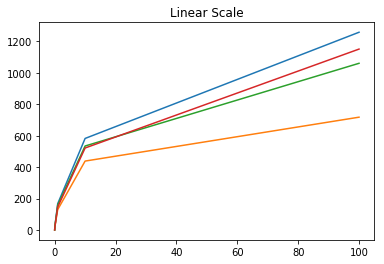

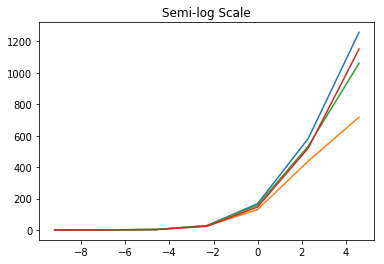

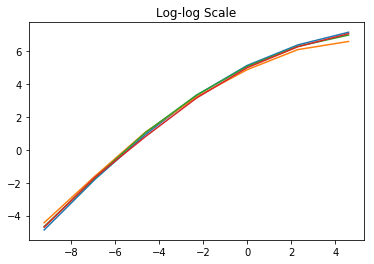

In [87]:
def P3():
    # vectorize
    vectorizer = CountVectorizer()
    train_matrix = vectorizer.fit_transform(train_data)
    dev_matrix = vectorizer.transform(dev_data)
    
    # -- kNN --
    print('kNN')
    # Implement GridSearchCV on Nearest Neighbors and find best k
    k = {'n_neighbors': [1, 2, 4, 8, 16, 32]}
    knn = GridSearchCV(KNeighborsClassifier(), k)
    knn.fit(train_matrix, train_labels)
    print('best k found was', knn.best_params_)
    print('best score on training data with cross-validation was', knn.best_score_)
    # test dev data with best model from cross-validation
    best_knn = KNeighborsClassifier(n_neighbors=knn.best_params_['n_neighbors'])
    best_knn.fit(train_matrix, train_labels)
    knn_predictions = best_knn.predict(dev_matrix)
    print('F1 score on dev data =', metrics.f1_score(knn_predictions, dev_labels, average='micro'))

    # -- Naive Bayes --
    print('\nNaive Bayes')
    # Implement GridSearchCV on Naive Bayes and find best alpha
    alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    nb = GridSearchCV(MultinomialNB(), alphas)
    nb.fit(train_matrix, train_labels)
    print('best alpha found was', nb.best_params_)
    print('best score on training data with cross-validation was', nb.best_score_)
    # test dev data with best model from cross-validation
    best_nb = MultinomialNB(alpha=nb.best_params_['alpha'])
    best_nb.fit(train_matrix, train_labels)
    nb_predictions = best_nb.predict(dev_matrix)
    print('F1 score on dev data =', metrics.f1_score(nb_predictions, dev_labels, average='micro'))
    
    # -- Logistic Regression --
    print('\nLogistic Regression')
    # Implement GridSearchCV on Logistic Regression and find best regularization C
    C = {'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
    lr = GridSearchCV(LogisticRegression(tol=.01), C)
    lr.fit(train_matrix, train_labels)
    print('best C found was', lr.best_params_)
    print('best score on training data with cross-validation was', lr.best_score_)
    # test dev data with best model from cross-validation
    best_lr = LogisticRegression(C=lr.best_params_['C'], tol=.01)
    best_lr.fit(train_matrix, train_labels)
    lr_predictions = best_lr.predict(dev_matrix)
    print('F1 score on dev data =', metrics.f1_score(lr_predictions, dev_labels, average='micro'))
    # Since GridSearchCV doesn't seem to have a way to access coefficients, I will explicitly loop over C values. This is
    # inefficient since I already implicitly did this with GridSearchCV above, but I don't want to refactor the previous work.
    matrix = np.empty((7, 4))
    i = 0
    C_list = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    for C in C_list:
        # reduce tolerance for faster computing. .001 is the minimum that doesn't produce "jumpy" plots
        logr = LogisticRegression(C=C, tol=.001)
        logr.fit(train_matrix, train_labels)
        # calculate sum of squared weights
        SSW = np.sum(np.square(logr.coef_), axis=1)
        print('C =', C, '\tSum of squared weights =', SSW)
        matrix[i,] = SSW
        i += 1
    # plot on three different scales to look for relationships
    plt.plot(C_list, matrix)
    plt.title('Linear Scale')
    plt.figure()
    plt.plot(np.log(C_list), matrix)
    plt.title('Semi-log Scale')
    plt.figure()
    plt.plot(np.log(C_list), np.log(matrix))
    plt.title('Log-log Scale')
    
P3()

ANSWER:  
I think that kNN is struggling with sparseness in the presense of high dimensionality. Even within a category, say "space", I would guess that different instances are not close at all geometrically. As a result, searching for nearest neighbors doesn't provide very good classification. Regarding Naive Bayes vs logistic regression, I believe the answer is in the training set size and generative vs. discriminative models. As a generative model, Naive Bayes more quickly approaches its asymptotic limit in accuracy. As a discriminative model, logistic regression takes longer to reach its asymptote, but given enough data, I believe it would outperform Naive Bayes. Finally, the logistic regression sum of squared weights are monotonically with the regularization parameter C, but neither linearly, exponentially, nor by a monomial, although the latter is the closest model.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [88]:
def P4():
    # run once for monograms and once for bigrams
    for vectorizer in [CountVectorizer(), CountVectorizer(analyzer='word', ngram_range=(2,3))]:
        # vectorize and fit logistic regression
        train_matrix = vectorizer.fit_transform(train_data)
        lr = LogisticRegression(C=0.1)
        lr.fit(train_matrix, train_labels)
        # initialize stores for top feature weights and features
        feature_weights = np.empty((20, 4))
        features = list()
        # for each category
        for row in range(0, 4):
            # grab indices of top five occurances
            ind = np.argpartition(lr.coef_[row,], -5)[-5:]
            # grab corresponding weights (from all categories)
            feature_weights[row*5:row*5+5,0:4] = np.transpose(lr.coef_[0:4, ind])
            # store features too, for easier interpretation
            features += list(np.array(vectorizer.get_feature_names())[ind])
        # put this all in a dataframe for nicer printing
        result = pd.DataFrame(feature_weights)
        result.columns = newsgroups_train.target_names
        feature_dict = {i:features[i] for i in range(0,20)}
        result.rename(index=feature_dict, inplace=True)
        print(result,'\n')

P4()

            alt.atheism  comp.graphics  sci.space  talk.religion.misc
islam          0.426277      -0.084811  -0.165051           -0.164917
atheists       0.461514      -0.079452  -0.158386           -0.295276
atheism        0.495546      -0.207279  -0.199914           -0.267745
bobby          0.478133      -0.120390  -0.167838           -0.227826
religion       0.493996      -0.298784  -0.393234            0.003896
3d            -0.181982       0.547008  -0.311630           -0.181439
computer      -0.039743       0.558997  -0.329037           -0.228689
image         -0.263628       0.642159  -0.367628           -0.216182
file          -0.177346       0.641275  -0.421582           -0.288273
graphics      -0.411110       1.007503  -0.651121           -0.372235
moon          -0.202777      -0.291488   0.403107           -0.056406
launch        -0.211027      -0.244642   0.478958           -0.169063
nasa          -0.273495      -0.261786   0.540866           -0.253110
orbit         -0.217

ANSWER:  
There are certainly a few surprises to both tables. I am surprised that atheism and religion don't overlap more in general. For example, the word "Christian" has a higher weight in space or computer graphics than in atheism. The bigrams have many more surprises. "Cheers kent" shows up in both atheism and religion. This seems to almost certainly be an example of overfitting. I can't imagine that that phrase generalizes well at all. The bigrams also notably contain several common words. This seems to suggest to me overfitting again and that the training data size was insufficient for a feature space so vast. A final conclusion from the monograms could be that similar words like "christian" and "christians" should be bucketed together, probably with some regular expressions preprocessing.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [89]:
def better_preprocessor(s, lemma_length, words_to_lemmatize):
    r = deepcopy(s)
    for i in range(len(s)):
        string = r[i]
        # force lowercase to reduce vocabulary and potential redundancy
        string = string.lower()
        # lemmatize previously selected candidates
        for item in words_to_lemmatize:
            string = string.replace(item, item[0:lemma_length])
        # find email addresses and replace with a common token
        string = re.sub('.{,20}@.{,20}','email',string)
        # find phone numbers and replace with a common token
        string = re.sub('\d{10}','phone',string)
        string = re.sub('\d{3}[\s-]{,1}\d{3}-\d{4}','phone',string)
        # removing any remaining underscores, which showed up in nonsensical ways in the vocabulary
        string = re.sub('_*','',string)
        # A variation on one of Porter's algorithm rules
        string = re.sub('ies\s','y',string)
        # for long words ending in 's', truncate the 's'
        to_replace = re.findall('\w{10,}s\s', string)
        for item in to_replace:
            string = string.replace(item, item[:-1])
        r[i] = string
    return r

def P5():
    # baseline method
    og_vectorizer = CountVectorizer()
    og_vectorizer.fit(train_data)
    train_matrix = og_vectorizer.fit_transform(train_data)
    dev_matrix = og_vectorizer.transform(dev_data)
    og_lr = LogisticRegression(C=.1)
    og_lr.fit(train_matrix, train_labels)
    og_lr_predictions = og_lr.predict(dev_matrix)
    print('Baseline F1 score =', metrics.f1_score(og_lr_predictions, dev_labels, average='micro'))
    
    # while we have that vocabulary accessible, decide what to lemmatize for later
    original_vocabulary = og_vectorizer.get_feature_names()
    words_to_lemmatize = set()
    # if the first n letters of the two words match, this will be considered the lemma
    lemma_length = 7
    # separate from lemma length, specify a minimum word length to be an eligible candidate
    min_word_length = 8
    for i in range(len(original_vocabulary)):
        word = original_vocabulary[i] 
        if len(word) >= min_word_length:
            # take advantage of sorted vocabulary. Look at following word(s) to find good candidates
            offset = 1
            try:
                # compare lemma of current word and candidate word
                while original_vocabulary[i+offset][0:lemma_length] == word[0:lemma_length]:
                    words_to_lemmatize.add(original_vocabulary[i+offset])
                    words_to_lemmatize.add(word)
                    # if you find a match loop again trying the immediate next word
                    offset += 1
            except:
                pass
            
    # pre-process data
    pp_train_data = better_preprocessor(train_data, lemma_length, words_to_lemmatize)
    pp_dev_data = better_preprocessor(dev_data, lemma_length, words_to_lemmatize)
    
    # vectorize, fit, transform with pre-processed data
    vectorizer = CountVectorizer()
    pp_train_matrix = vectorizer.fit_transform(pp_train_data)
    pp_dev_matrix = vectorizer.transform(pp_dev_data)
    lr = LogisticRegression(C=.1)
    lr.fit(pp_train_matrix, train_labels)
    
    # test dev data
    lr_predictions = lr.predict(pp_dev_matrix)
    print('Improved F1 score =', metrics.f1_score(lr_predictions, dev_labels, average='micro'))
    
P5()

Baseline F1 score = 0.7041420118343196
Improved F1 score = 0.7233727810650887


ANSWER:  
I tried several stemming attempts per Porter's algorithm. In fact I originally imported `PorterStemmer` from the library `nltk.stem` out of curiosity and ran it as is, but it decreased performance. This led me to go through some of the rules "a la carte" and select the ones that increased performance on the development data. Some were successful and are included above, but others (ex. `sses` → `ss`) were unsuccessful and I removed them from the script.  
  
Some other unsuccessful attempts include tokenizing long numbers (such as dates or phone numbers perhaps) as zeroes, arbitrarily shortening longs words, and removing other symbols. All of these hurt accuracy and were abandoned.  
  
I also attempted lemmatization, automating a way to cast words such as `atmospheres`, `atmospheric`, `atmospherics`, and `atmospherique` as `atmosphere`. This had an additional marginal benefit to F1.

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

C = 0.01 	Vocab size = 22 	L1 zero coef = 107465 	L2 zero coef = 0   Original F1 = 0.6731  Pruned F1 = 0.4512
C = 0.037 	Vocab size = 104 	L1 zero coef = 107330 	L2 zero coef = 0   Original F1 = 0.6849  Pruned F1 = 0.568
C = 0.139 	Vocab size = 314 	L1 zero coef = 106927 	L2 zero coef = 0   Original F1 = 0.6834  Pruned F1 = 0.676
C = 0.518 	Vocab size = 1100 	L1 zero coef = 105848 	L2 zero coef = 0   Original F1 = 0.676  Pruned F1 = 0.6864
C = 1.931 	Vocab size = 3089 	L1 zero coef = 101633 	L2 zero coef = 0   Original F1 = 0.7027  Pruned F1 = 0.6583
C = 7.197 	Vocab size = 6198 	L1 zero coef = 93978 	L2 zero coef = 0   Original F1 = 0.6805  Pruned F1 = 0.6642
C = 26.827 	Vocab size = 13115 	L1 zero coef = 81115 	L2 zero coef = 0   Original F1 = 0.6864  Pruned F1 = 0.6317
C = 100.0 	Vocab size = 19885 	L1 zero coef = 58149 	L2 zero coef = 0   Original F1 = 0.6938  Pruned F1 = 0.6243


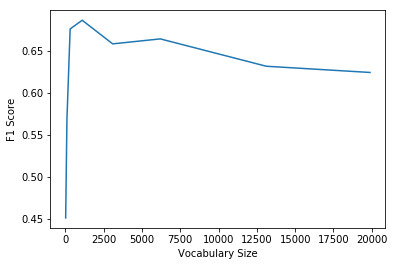

In [92]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    # vectorize
    vectorizer = CountVectorizer()
    train_matrix = vectorizer.fit_transform(train_data)
    dev_matrix = vectorizer.transform(dev_data)

    # Test out L1 and L2 regularization in the context of zero-valued coefficients
    # the following linspace produces a fairly interesting plot
    C_list = np.power([10.0]*8, np.linspace(-2.0, 2.0, 8))
    vocab_sizes = []
    scores = []
    for C in C_list:
        # fit both models
        lr_l1 = LogisticRegression(C=C, penalty='l1', tol=.1)
        lr_l1.fit(train_matrix, train_labels)
        lr_l2 = LogisticRegression(C=C, penalty='l2', tol=.1)
        lr_l2.fit(train_matrix, train_labels)
        # grab zero coefficients
        zero_coef_l1 = np.sum(lr_l1.coef_ == 0)
        zero_coef_l2 = np.sum(lr_l2.coef_ == 0)
        # train a L1 model to reduce vocabulary
        lr_l1_test = LogisticRegression(C=C, penalty='l1', tol=.1)
        lr_l1_test.fit(train_matrix, train_labels)
        useful_words = np.array(vectorizer.get_feature_names())[np.sum(lr_l1_test.coef_, axis=0) != 0]
        vocab_sizes.append(len(useful_words))
        # new vectorizer with reduced vocabulary
        vectorizer2 = CountVectorizer(vocabulary=useful_words)
        train_matrix2 = vectorizer.fit_transform(train_data)
        dev_matrix2 = vectorizer.transform(dev_data)
        # train an L2 model with this reduced vocabulary
        lr_l2_test = LogisticRegression(C=C, penalty='l1', tol=.1)
        lr_l2_test.fit(train_matrix2, train_labels)
        # test original and pruned methods on dev data
        lr_predictions = lr_l2.predict(dev_matrix2)
        lr_predictions2 = lr_l2_test.predict(dev_matrix2)
        original_score = metrics.f1_score(lr_predictions, dev_labels, average='micro')
        new_score = metrics.f1_score(lr_predictions2, dev_labels, average='micro')
        scores.append(new_score)
        print('C =', round(C, 3), '\tVocab size =', len(useful_words), '\tL1 zero coef =', zero_coef_l1,
              '\tL2 zero coef =', zero_coef_l2, '  Original F1 =', round(original_score, 4),' Pruned F1 =', round(new_score, 4))
    plt.plot(vocab_sizes, scores)
    plt.xlabel('Vocabulary Size')
    plt.ylabel('F1 Score')
        
P6()

ANSWER:  
L2 regularization never produces weights of exactly zero in my experience. See above printout for examples. Interestingly, pruning the vocab help my F1 scores. I printed out, for each C value, what score the original (full) vocabulary produced as well as the score for the supposedly optimized vocabulary. The original score dominated the new score in nearly all cases.

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [93]:
def P7():
    vectorizer = TfidfVectorizer()
    train_matrix = vectorizer.fit_transform(train_data)
    dev_matrix = vectorizer.transform(dev_data)
    lr = LogisticRegression(C=100, tol=.001)
    lr.fit(train_matrix, train_labels)
    lr_prediction_probs = lr.predict_proba(dev_matrix)
    lr_predictions = lr.predict(dev_matrix)
    # Calculate R = maximum predicted probability / predicted probability of the correct label
    R = np.max(lr_prediction_probs, axis=1) / [lr_prediction_probs[i, dev_labels[i]] for i in range(len(dev_labels))]
    # find three biggest mistakes using R as the criterion
    ind = np.argpartition(R, -3)[-3:]
    # print what was predicted and what the actual class was, as well as the text of the document
    for i in ind:
        print('Predicted', newsgroups_train.target_names[lr_predictions[i]],
              'but was', newsgroups_train.target_names[dev_labels[i]], '\n')
        print(dev_data[i], '\n--------------------------------\n')
    
P7()

Predicted talk.religion.misc but was alt.atheism 


The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...
 
--------------------------------

Predicted comp.graphics but was talk.religion.misc 

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible. 
--------------------------------

Predicted comp.graphics but was talk.religion.misc 

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witness

ANSWER:  
The tf-idf doesn't just count occurences, but compares occurence rate in the current document of text to rate in the global population of documents.  
  
For the first example, it is not clear why the mistake was made and why the algorithm was so overconfident. As a human I can't tell which category that one belongs to.  
  
The second and third examples are much more clear. Both are discussions about religion but contain numerous references to computer language (ex. `online`, `internet`, `site`, file types, read/write permissions, etc.). It's difficult to say with certainty how to handle this because even as a human I would have to spend a bit of time deciding whether these belong under religion or computer graphics. A quick naive idea is to strip out potentially confusing and overlapping words such as `email`, but I fear this would harm the accuracy overall, even if it might improve these edge cases. One problem may be that it is considering words such as `Mormon` to be common because there are many religious documents, so that word doesn't count for much in example three. This leads me to think that it could be useful to run a regular CountVectorizer as well as a tf-idf vectorizer and evaluate each ones probabilities to make a synthesized prediction.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance